<a href="https://colab.research.google.com/github/ewboyeff/AI-speacial/blob/main/Movie_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Kerakli kutubxonalarni import qilish
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import urllib.request
import zipfile
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Ma'lumotlarni yuklab olish
def fetch_movielens_data():
    """MovieLens 1M datasetini yuklab oladi va ochadi"""
    dataset_url = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
    if not os.path.exists("movielens_data"):
        print("Ma'lumotlar yuklanmoqda...")
        urllib.request.urlretrieve(dataset_url, "ml-1m.zip")
        with zipfile.ZipFile("ml-1m.zip", "r") as zip_ref:
            zip_ref.extractall("movielens_data")
        print("Ma'lumotlar muvaffaqiyatli yuklandi!")
    else:
        print("Ma'lumotlar allaqachon mavjud.")

In [3]:
# Ma'lumotlarni o'qish
def load_data():
    """Ma'lumotlarni pandas DataFrame sifatida o'qiydi"""
    data_dir = 'movielens_data/ml-1m'

    # Foydalanuvchilar
    user_columns = ['user_id', 'gender', 'age', 'occupation', 'zip_code']
    users_df = pd.read_csv(os.path.join(data_dir, 'users.dat'),
                          sep='::', names=user_columns, engine='python', encoding='latin-1')

    # Filmlar
    movie_columns = ['movie_id', 'title', 'genres']
    movies_df = pd.read_csv(os.path.join(data_dir, 'movies.dat'),
                           sep='::', names=movie_columns, engine='python', encoding='latin-1')

    # Reytinglar
    rating_columns = ['user_id', 'movie_id', 'rating', 'timestamp']
    ratings_df = pd.read_csv(os.path.join(data_dir, 'ratings.dat'),
                            sep='::', names=rating_columns, engine='python', encoding='latin-1')

    return users_df, movies_df, ratings_df

In [4]:
# Ma'lumotlarni tahlil qilish
def analyze_data(users_df, movies_df, ratings_df):
    """Ma'lumotlarni tahlil qiladi va vizualizatsiya qiladi"""
    print("Foydalanuvchilar ma'lumotlari:")
    print(users_df.head())
    print(f"Foydalanuvchilar soni: {users_df.shape[0]}")

    print("\nFilmlar ma'lumotlari:")
    print(movies_df.head())
    print(f"Filmlar soni: {movies_df.shape[0]}")

    print("\nReytinglar statistikasi:")
    print(ratings_df['rating'].describe())

    # Reytinglar taqsimoti
    plt.figure(figsize=(10, 6))
    sns.histplot(ratings_df['rating'], bins=5, kde=False)
    plt.title('Reytinglarning Taqsimoti')
    plt.xlabel('Reyting')
    plt.ylabel('Soni')
    plt.show()

    # Janrlar tahlili
    genres_set = set()
    for genre_list in movies_df['genres'].str.split('|'):
        genres_set.update(genre_list)

    genre_counts = pd.Series([genre for genre_list in movies_df['genres'].str.split('|') for genre in genre_list]).value_counts()
    plt.figure(figsize=(12, 6))
    sns.barplot(x=genre_counts.values, y=genre_counts.index)
    plt.title('Janrlar bo\'yicha Filmlar Soni')
    plt.xlabel('Filmlar soni')
    plt.show()

In [5]:
# Ma'lumotlarni tayyorlash
def prepare_data(ratings_df):
    """Ma'lumotlarni o'qitish, validatsiya va test to'plamlariga ajratadi"""
    ratings_df['date'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
    ratings_df = ratings_df.sort_values('timestamp')

    train_size = int(0.7 * len(ratings_df))
    val_size = int(0.15 * len(ratings_df))

    train_df = ratings_df.iloc[:train_size]
    val_df = ratings_df.iloc[train_size:train_size + val_size]
    test_df = ratings_df.iloc[train_size + val_size:]

    return train_df, val_df, test_df

In [6]:
# Sparse matritsa yaratish
def build_rating_matrix(data):
    """Foydalanuvchi-film reyting matritsasini yaratadi"""
    user_ids = data['user_id'].unique()
    movie_ids = data['movie_id'].unique()

    user_map = {uid: idx for idx, uid in enumerate(user_ids)}
    movie_map = {mid: idx for idx, mid in enumerate(movie_ids)}

    row_indices = [user_map[uid] for uid in data['user_id']]
    col_indices = [movie_map[mid] for mid in data['movie_id']]

    matrix = sparse.coo_matrix((data['rating'], (row_indices, col_indices)),
                              shape=(len(user_ids), len(movie_ids))).tocsr()

    return matrix, user_map, movie_map

In [7]:
# SVD Modeli
class MatrixFactorization:
    def __init__(self, n_factors=50, lr=0.01, reg=0.02, epochs=15):
        self.n_factors = n_factors
        self.lr = lr
        self.reg = reg
        self.epochs = epochs

    def train(self, train_df, val_df=None):
        self.user_map = {uid: idx for idx, uid in enumerate(train_df['user_id'].unique())}
        self.movie_map = {mid: idx for idx, mid in enumerate(train_df['movie_id'].unique())}

        self.n_users = len(self.user_map)
        self.n_movies = len(self.movie_map)

        self.user_factors = np.random.normal(0, 0.1, (self.n_users, self.n_factors))
        self.movie_factors = np.random.normal(0, 0.1, (self.n_movies, self.n_factors))
        self.user_bias = np.zeros(self.n_users)
        self.movie_bias = np.zeros(self.n_movies)
        self.global_mean = train_df['rating'].mean()

        train_errors = []
        val_errors = []

        for epoch in range(self.epochs):
            for _, row in train_df.sample(frac=1).iterrows():
                u_id, m_id, rating = row['user_id'], row['movie_id'], row['rating']
                if u_id not in self.user_map or m_id not in self.movie_map:
                    continue

                u_idx = self.user_map[u_id]
                m_idx = self.movie_map[m_id]

                pred = self.global_mean + self.user_bias[u_idx] + self.movie_bias[m_idx] + \
                       np.dot(self.user_factors[u_idx], self.movie_factors[m_idx])
                error = rating - pred

                self.user_bias[u_idx] += self.lr * (error - self.reg * self.user_bias[u_idx])
                self.movie_bias[m_idx] += self.lr * (error - self.reg * self.movie_bias[m_idx])

                u_factor_update = self.lr * (error * self.movie_factors[m_idx] - self.reg * self.user_factors[u_idx])
                m_factor_update = self.lr * (error * self.user_factors[u_idx] - self.reg * self.movie_factors[m_idx])

                self.user_factors[u_idx] += u_factor_update
                self.movie_factors[m_idx] += m_factor_update

            train_rmse = self.compute_rmse(train_df)
            train_errors.append(train_rmse)
            if val_df is not None:
                val_rmse = self.compute_rmse(val_df)
                val_errors.append(val_rmse)
                print(f"Davr {epoch+1}/{self.epochs}: O'qitish RMSE: {train_rmse:.4f}, Validatsiya RMSE: {val_rmse:.4f}")

        return train_errors, val_errors

    def predict(self, user_id, movie_id):
        if user_id not in self.user_map or movie_id not in self.movie_map:
            return self.global_mean
        u_idx = self.user_map[user_id]
        m_idx = self.movie_map[movie_id]
        pred = self.global_mean + self.user_bias[u_idx] + self.movie_bias[m_idx] + \
               np.dot(self.user_factors[u_idx], self.movie_factors[m_idx])
        return max(1, min(5, pred))

    def recommend(self, user_id, n=10, exclude_seen=True):
        if user_id not in self.user_map:
            return self.popular_movies(n)

        rated_movies = set(train_data[train_data['user_id'] == user_id]['movie_id'])
        movie_ids = [mid for mid in self.movie_map.keys() if mid not in rated_movies or not exclude_seen]

        predictions = [(mid, self.predict(user_id, mid)) for mid in movie_ids]
        predictions.sort(key=lambda x: x[1], reverse=True)
        return predictions[:n]

    def popular_movies(self, n=10):
        movie_stats = train_data.groupby('movie_id')['rating'].agg(['count', 'mean']).reset_index()
        movie_stats['score'] = movie_stats['mean'] * (movie_stats['count'] / movie_stats['count'].max())
        top_movies = movie_stats.sort_values('score', ascending=False).head(n)
        return [(row['movie_id'], row['mean']) for _, row in top_movies.iterrows()]

    def compute_rmse(self, data):
        preds = [self.predict(row['user_id'], row['movie_id']) for _, row in data.iterrows()]
        return np.sqrt(mean_squared_error(data['rating'], preds))

In [8]:
# Neural Collaborative Filtering Modeli
def build_ncf_model(n_users, n_movies, emb_size=50):
    user_input = keras.Input(shape=(1,), name='user')
    user_emb = layers.Embedding(n_users + 1, emb_size)(user_input)
    user_vec = layers.Flatten()(user_emb)

    movie_input = keras.Input(shape=(1,), name='movie')
    movie_emb = layers.Embedding(n_movies + 1, emb_size)(movie_input)
    movie_vec = layers.Flatten()(movie_emb)

    concat = layers.Concatenate()([user_vec, movie_vec])
    dense = layers.Dense(100, activation='relu')(concat)
    dense = layers.Dropout(0.3)(dense)
    dense = layers.Dense(50, activation='relu')(dense)
    output = layers.Dense(1)(dense)

    model = keras.Model(inputs=[user_input, movie_input], outputs=output)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model

In [9]:
# Reinforcement Learning Muhiti
class FilmRecommendationEnv:
    def __init__(self, ratings_df, movies_df, mf_model, n_actions=15):
        self.ratings_df = ratings_df
        self.movies_df = movies_df
        self.mf_model = mf_model
        self.n_actions = n_actions
        self.movie_ids = set(movies_df['movie_id'])
        self.current_user = None
        self.seen_movies = set()
        self.step_count = 0
        self.max_steps = 10

    def reset(self, user_id=None):
        self.current_user = user_id or np.random.choice(self.ratings_df['user_id'].unique())
        self.seen_movies = set(self.ratings_df[self.ratings_df['user_id'] == self.current_user]['movie_id'])
        self.step_count = 0

        user_info = users[users['user_id'] == self.current_user].iloc[0]
        return {
            'user_id': self.current_user,
            'gender': user_info['gender'],
            'age': user_info['age'],
            'occupation': user_info['occupation'],
            'seen_movies': list(self.seen_movies)
        }

    def step(self, action_idx):
        movie_id = self.get_available_movies()[action_idx]
        if movie_id in self.seen_movies:
            reward = -0.5
        else:
            actual_rating = self.ratings_df[
                (self.ratings_df['user_id'] == self.current_user) &
                (self.ratings_df['movie_id'] == movie_id)
            ]
            reward = (actual_rating['rating'].iloc[0] - 3.0) if not actual_rating.empty else \
                     (self.mf_model.predict(self.current_user, movie_id) - 3.0)
            self.seen_movies.add(movie_id)

        self.step_count += 1
        done = self.step_count >= self.max_steps

        next_state = self.reset(self.current_user) if done else {
            'user_id': self.current_user,
            'gender': users[users['user_id'] == self.current_user].iloc[0]['gender'],
            'age': users[users['user_id'] == self.current_user].iloc[0]['age'],
            'occupation': users[users['user_id'] == self.current_user].iloc[0]['occupation'],
            'seen_movies': list(self.seen_movies)
        }

        info = {'movie_id': movie_id, 'title': self.movies_df[self.movies_df['movie_id'] == movie_id]['title'].iloc[0]}
        return next_state, reward, done, info

    def get_available_movies(self):
        unwatched = list(self.movie_ids - self.seen_movies)
        if len(unwatched) > self.n_actions:
            preds = [(mid, self.mf_model.predict(self.current_user, mid)) for mid in unwatched]
            preds.sort(key=lambda x: x[1], reverse=True)
            return [p[0] for p in preds[:self.n_actions]]
        return unwatched

In [10]:
# Q-Learning Agent
class RLAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.9, exploration_rate=0.1):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.q_values = {}

    def get_state_key(self, state):
        return (state['user_id'], len(state['seen_movies']))

    def get_action(self, state):
        state_key = self.get_state_key(state)
        actions = self.env.get_available_movies()
        if state_key not in self.q_values:
            self.q_values[state_key] = [0.0] * len(actions)

        if np.random.random() < self.exploration_rate:
            return np.random.randint(len(actions))
        return np.argmax(self.q_values[state_key])

    def update_q(self, state, action, reward, next_state):
        state_key = self.get_state_key(state)
        next_key = self.get_state_key(next_state)

        if next_key not in self.q_values:
            self.q_values[next_key] = [0.0] * len(self.env.get_available_movies())

        current_q = self.q_values[state_key][action]
        next_max_q = max(self.q_values[next_key]) if self.q_values[next_key] else 0
        self.q_values[state_key][action] = current_q + self.learning_rate * \
                                          (reward + self.discount_factor * next_max_q - current_q)

    def train(self, episodes=300):
        rewards = []
        for ep in range(episodes):
            state = self.env.reset()
            total_reward = 0
            done = False
            while not done:
                action = self.get_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.update_q(state, action, reward, next_state)
                state = next_state
                total_reward += reward
            rewards.append(total_reward)
            if ep % 50 == 0:
                print(f"Epizod {ep}/{episodes}, Mukofot: {total_reward:.2f}")
        return rewards


In [11]:
# Interfeys yaratish
def create_ui(ratings_df, movies_df, users_df, mf_model, rl_agent):
    header = widgets.HTML(value="<h2>Film Tavsiya Tizimi</h2>")
    user_selector = widgets.Dropdown(options=[('Tasodifiy', 0)] + [(f"User {uid}", uid) for uid in ratings_df['user_id'].unique()[:50]],
                                    value=0, description='Foydalanuvchi:')
    method_selector = widgets.RadioButtons(options=['Matrix Factorization', 'RL Agent'], value='Matrix Factorization')
    n_recs = widgets.IntSlider(value=5, min=1, max=15, description='Tavsiyalar:')
    button = widgets.Button(description='Tavsiyalarni Ko\'rsat', button_style='success')
    output = widgets.Output()

    def on_button_clicked(b):
        with output:
            clear_output()
            user_id = user_selector.value or random.choice(ratings_df['user_id'].unique())
            method = method_selector.value
            n = n_recs.value

            user_info = users_df[users_df['user_id'] == user_id].iloc[0]
            html_out = f"<h3>Foydalanuvchi {user_id} uchun Tavsiyalar</h3>"
            html_out += f"Jins: {user_info['gender']}<br>Yosh: {user_info['age']}<br>Kasb: {user_info['occupation']}<br>"

            if method == 'Matrix Factorization':
                recs = mf_model.recommend(user_id, n)
                html_out += "<h4>Matrix Factorization Tavsiyalari</h4>"
                for i, (mid, pred) in enumerate(recs, 1):
                    title = movies_df[movies_df['movie_id'] == mid]['title'].iloc[0]
                    genres = movies_df[movies_df['movie_id'] == mid]['genres'].iloc[0]
                    html_out += f"{i}. {title} (Janr: {genres}, Bashorat: {pred:.2f})<br>"
            else:
                recs = rl_agent.env.reset(user_id)
                html_out += "<h4>RL Agent Tavsiyalari</h4>"
                for i in range(n):
                    action = rl_agent.get_action(recs)
                    next_state, reward, done, info = rl_agent.env.step(action)
                    html_out += f"{i+1}. {info['title']} (Janr: {movies_df[movies_df['movie_id'] == info['movie_id']]['genres'].iloc[0]}, Mukofot: {reward:.2f})<br>"
                    recs = next_state
                    if done:
                        break

            display(HTML(html_out))

    button.on_click(on_button_clicked)
    interface = widgets.VBox([header, user_selector, method_selector, n_recs, button, output])
    return interface

Ma'lumotlar yuklanmoqda...
Ma'lumotlar muvaffaqiyatli yuklandi!
Foydalanuvchilar ma'lumotlari:
   user_id gender  age  occupation zip_code
0        1      F    1          10    48067
1        2      M   56          16    70072
2        3      M   25          15    55117
3        4      M   45           7    02460
4        5      M   25          20    55455
Foydalanuvchilar soni: 6040

Filmlar ma'lumotlari:
   movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy
Filmlar soni: 3883

Reytinglar statistikasi:
count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.

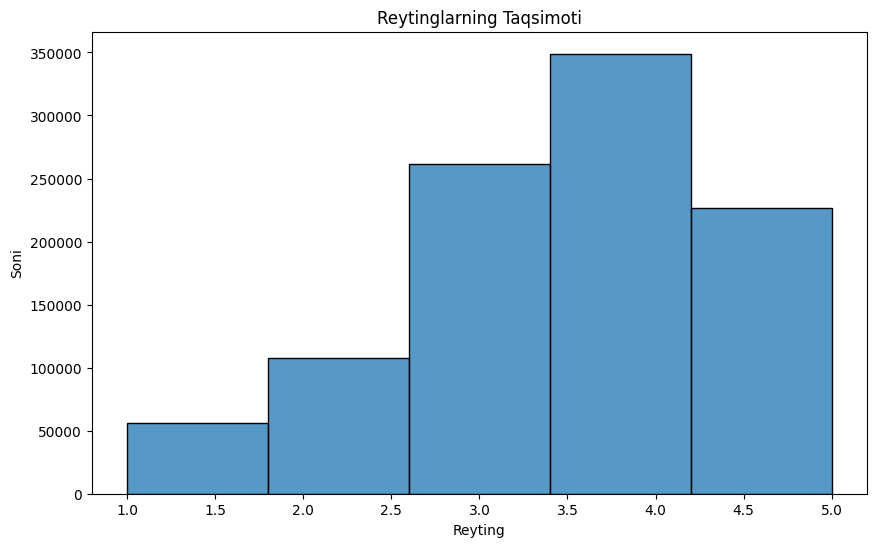

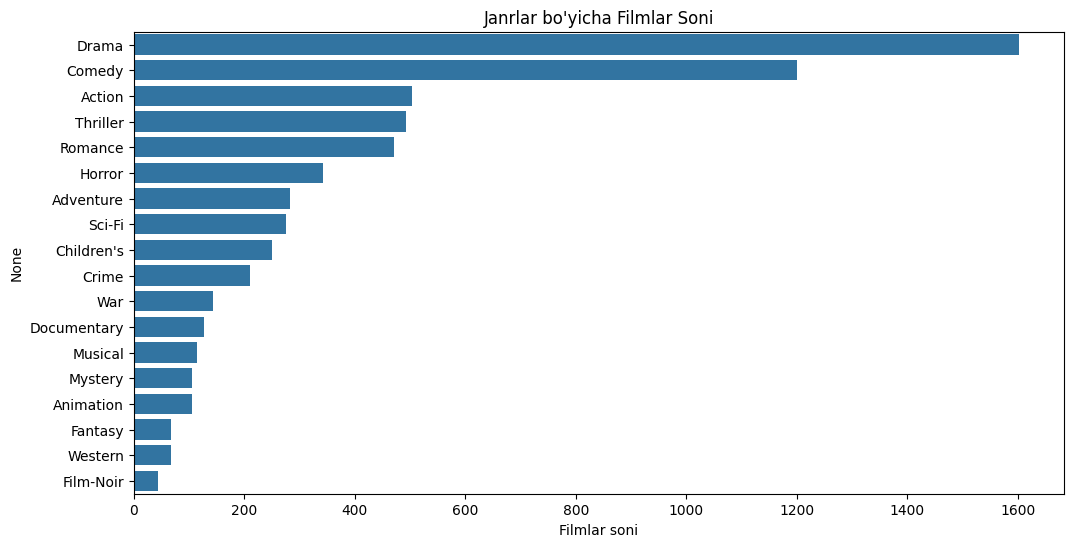

In [12]:
# Asosiy dastur
if __name__ == "__main__":
    fetch_movielens_data()
    users, movies, ratings = load_data()
    analyze_data(users, movies, ratings)
    train_data, val_data, test_data = prepare_data(ratings)

In [13]:
    # SVD Model
    mf_model = MatrixFactorization(n_factors=50, lr=0.01, reg=0.02, epochs=10)
    train_errors, val_errors = mf_model.train(train_data, val_data)
    print(f"Test RMSE: {mf_model.compute_rmse(test_data):.4f}")


Davr 1/10: O'qitish RMSE: 0.9138, Validatsiya RMSE: 1.0910
Davr 2/10: O'qitish RMSE: 0.8957, Validatsiya RMSE: 1.0891
Davr 3/10: O'qitish RMSE: 0.8828, Validatsiya RMSE: 1.0880
Davr 4/10: O'qitish RMSE: 0.8667, Validatsiya RMSE: 1.0875
Davr 5/10: O'qitish RMSE: 0.8470, Validatsiya RMSE: 1.0863
Davr 6/10: O'qitish RMSE: 0.8261, Validatsiya RMSE: 1.0858
Davr 7/10: O'qitish RMSE: 0.8045, Validatsiya RMSE: 1.0854
Davr 8/10: O'qitish RMSE: 0.7831, Validatsiya RMSE: 1.0849
Davr 9/10: O'qitish RMSE: 0.7625, Validatsiya RMSE: 1.0849
Davr 10/10: O'qitish RMSE: 0.7435, Validatsiya RMSE: 1.0849
Test RMSE: 1.0127


In [15]:
    # Neural Collaborative Filtering
    ncf_model = build_ncf_model(users['user_id'].max(), movies['movie_id'].max())
    train_features, train_labels = [train_data['user_id'].values, train_data['movie_id'].values], train_data['rating'].values
    ncf_model.fit(train_features, train_labels, epochs=5, batch_size=64, verbose=0)

In [16]:
    # Reinforcement Learning
    rl_env = FilmRecommendationEnv(train_data, movies, mf_model)
    rl_agent = RLAgent(rl_env)
    rewards = rl_agent.train(episodes=300)

Epizod 0/300, Mukofot: 10.72
Epizod 50/300, Mukofot: 12.24
Epizod 100/300, Mukofot: 19.88
Epizod 150/300, Mukofot: 12.02
Epizod 200/300, Mukofot: 19.19
Epizod 250/300, Mukofot: 15.92


In [17]:
    # Interfeys
    interface = create_ui(ratings, movies, users, mf_model, rl_agent)
    display(interface)